In [1]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import pandas as pd
df_tpfp = pd.read_csv('../../Submissions/CUtIe/final_data_fixed/tpfp.csv', sep = ',')
df_tpfp = df_tpfp.iloc[0:8].set_index('Statistic')
df_tpfp = df_tpfp.apply(pd.to_numeric).round(2)
df_tnfn = pd.read_csv('../../Submissions/CUtIe/final_data_fixed/tnfn.csv', sep = ',')
df_tnfn = df_tnfn.iloc[0:8].set_index('Statistic')
df_tnfn = df_tnfn.apply(pd.to_numeric).round(2)


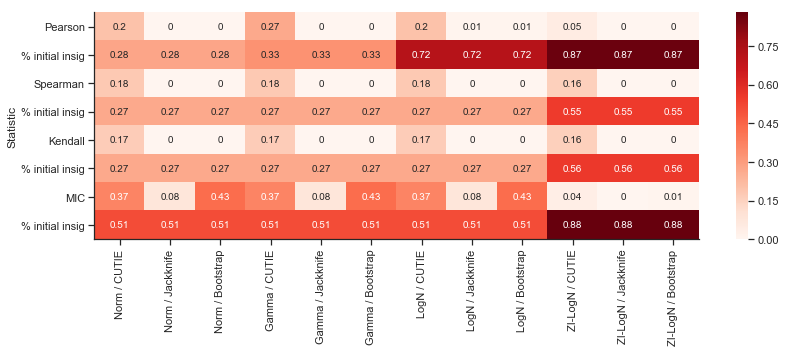

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
sns.heatmap(df_tnfn, annot=True, ax=ax, cmap="Reds")
sns.despine()
fig.tight_layout()

fig.savefig('sim_TNFN.png')

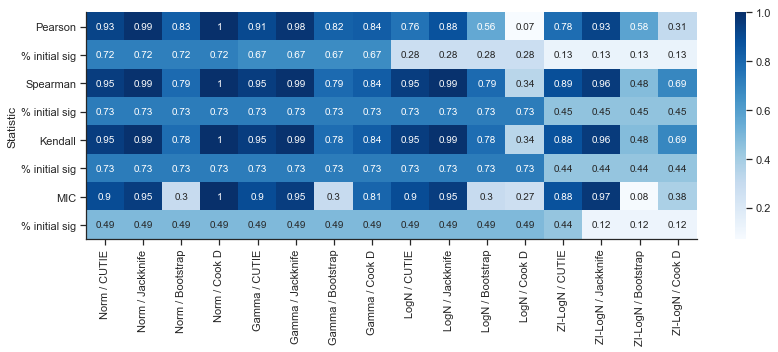

In [9]:
import matplotlib.pyplot as plt
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
sns.heatmap(df_tpfp, annot=True, ax=ax, cmap="Blues")
sns.despine()
fig.tight_layout()

fig.savefig('sim_TPFP.png')

In [4]:
df_real_tpfp = pd.read_csv('../../Submissions/CUtIe/final_data_fixed/real_tpfp.csv', sep = ',')
df_real_tpfp = df_real_tpfp.iloc[0:8].set_index('Statistic')
df_real_tnfn = pd.read_csv('../../Submissions/CUtIe/final_data_fixed/real_tnfn.csv', sep = ',')
df_real_tnfn = df_real_tnfn.iloc[0:8].set_index('Statistic')
df_real_tnfn = df_real_tnfn.apply(pd.to_numeric).round(2)
df_real_tpfp = df_real_tpfp.apply(pd.to_numeric).round(2)

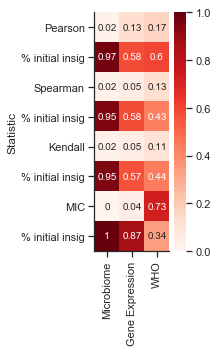

In [7]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(3, 5)
sns.heatmap(df_real_tnfn, annot=True, ax=ax, cmap="Reds")
sns.despine()
fig.tight_layout()
fig.savefig('real_TNFN.png')

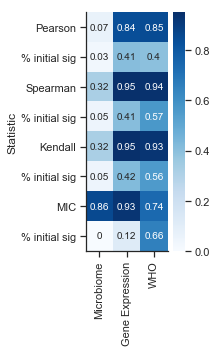

In [8]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(3, 5)
sns.heatmap(df_real_tpfp, annot=True, ax=ax, cmap="Blues")
sns.despine()
fig.tight_layout()
fig.savefig('real_TPFP.png')

In [20]:
def read_taxa(taxa, delim = ';'):
    """
    Converts string of OTU names (e.g. from QIIME) to shortened form.
    ----------------------------------------------------------------------------
    INPUTS
    taxa  - String. Long name of OTU e.g. 'k__Archaea;p__Crenarchaeota;
            c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;
            g__Nitrosopumilus' which will become 'Cenarchaeaceae Nitrosopumilus'
    delim - String. Separates heirarchy. 
    
    OUTPUTS
    String. Abridged taxa name.
    """    
    parts = taxa.split(delim) # set as param with default
    if len(parts) > 1:
        while parts:
            if not parts[-1].endswith('__'):
                t1 = parts[-2].split('__')[1] 
                t2 = parts[-1].split('__')[1]
                return t1 + ' ' + t2
            else:
                parts.pop()
    else:
        return parts[0]

    # This should not be reached: "k__;p__..."
    return 'Uncharacterized'


In [39]:
def plot_corr(row, f1type, f2type, var1_names, var2_names, 
    samp_var1, samp_var2, sim, resample_k, exceeds_points, rev_points, 
    fix_axis, var1_max, var1_min, var2_max, var2_min):

    var1, var2 = int(row['var1_index']), int(row['var2_index'])

    # obtain variable values
    x = samp_var1[:,var1]
    y = samp_var2[:,var2]
    var1_name = var1_names[var1]
    var2_name = var2_names[var2]

    # if the ftype is OTU, reduce the taxa name into abridged form
    if f1type == 'otu' and not sim:
        var1_name = read_taxa(var1_name)            
    if f2type == 'otu' and not sim:
        var2_name = read_taxa(var2_name) 

    # shorten var name
    var1_name = var1_name[0:25]
    var2_name = var2_name[0:25]

    # consolidate variables into pd dataframe
    # example:
    # let cutie = np.array([0,0,0,1,1])
    # let reverse = np.array([0,0,1,0,1])
    # want [0, 0, 0, 1, 2]
    # take c*(c+r)
    pair = var1, var2
    #cutie = exceeds_points[str(resample_k)][str(pair)] 
    #cutie = np.array([1 if z > 0 else 0 for z in cutie])
    #reverse = rev_points[str(resample_k)][str(pair)] 
    #reverse = np.array([1 if z > 0 else 0 for z in reverse])

    #cr = cutie*(cutie+reverse)
    cr = np.zeros(np.size(samp_var1, 0))
    pair_df = pd.DataFrame({var1_name:x, var2_name:y, 'cr': cr})
    pair_df = pair_df.dropna(how='any')

    # create plot and title
    title = 'p, ext_p = ' + '%.2E' % Decimal(row['pvalues']) + \
            ', ' + '%.2E' % Decimal(row['extreme_p']) + ' ' + \
            'Rsq, ext_r2 = ' + '%.2E' % Decimal(row['r2vals']) + \
            ', ' + '%.2E' % Decimal(row['extreme_r'])
    if sim:
        title = title + '_' + 'truth = ' + '%.2E' % Decimal(row['truth'])

    fig = plt.figure()
    sns_plot = sns.lmplot(var1_name, var2_name, data=pair_df, hue='cr', 
        fit_reg=False)
    if fix_axis:
        sns_plot.set(xlim = (var1_min, var1_max), ylim = (var2_min, var2_max))
    ax = plt.gca()
    ax.set_title(title, fontsize=8)
    fig.patch.set_visible(False)
    ax.patch.set_visible(False)

    plt.close()

In [40]:
import numpy as np
test = np.array([[1,2,3],[2,3,4]])
print np.nanmax(test)

4


In [42]:
# WHO plotting
df_who = pd.read_csv('data/MINE/WHOfix.txt', sep = '\t')


row = {}
row['var1_index'] = 1
row['var2_index'] = 2
f1type = 'map'
f2type = 'map'
var1_names = df_who.columns.values
var2_names = df_who.columns.values
samp_var1 = df_who.values
samp_var2 = df_who.values
sim = False
resample_k = 1
exceeds_points = {}
exceeds_points['1'] = np.zeros(np.size(test, 0))
rev_points = {}
rev_points['1'] = np.zeros(np.size(test, 0))
fix_axis = False
var1_max = np.nanmax(samp_var1)
var2_max = np.nanmax(samp_var2)
var1_min = np.nanmin(samp_var1)
var2_min = np.nanmin(samp_var2)


from decimal import Decimal  
%matplotlib inline
plot_corr(row, f1type, f2type, var1_names, var2_names, 
    samp_var1, samp_var2, sim, resample_k, exceeds_points, rev_points, 
    fix_axis, var1_max, var1_min, var2_max, var2_min)

KeyError: 'pvalues'

In [ ]:
# HDAC plotting



In [ ]:
# Microbiome plotting





In [15]:
cutie = np.array([0,0,0,1,1])
reverse = np.array([0,0,1,0,1])
# want [0, 0, 0, 1, 2]
# take c*(c+r)

cr = cutie*(cutie+reverse)

# obtain variable values
x = np.array([1,2,3,4,5])
y = np.array([1,2,3,4,5])
var1_name = 'x'
var2_name = 'y'

var1_name = var1_name[0:25]
var2_name = var2_name[0:25]

# consolidate variables into pd dataframe
cr = cutie*(cutie+reverse)
pair_df = pd.DataFrame({var1_name:x, var2_name:y, 'cr': cr})
pair_df = pair_df.dropna(how='any')

# create plot and title

fig = plt.figure()
sns_plot = sns.lmplot(var1_name, var2_name, data=pair_df, hue='cr',fit_reg=False)
sns_plot.set(ylim=(0, 5))
sns_plot.set(xlim=(0, 5))
ax = plt.gca()
ax.set_title('ho', fontsize=8)
plt.savefig('test.png')
plt.close()

In [ ]:
path = 'cutie_lungc_'
stats = ['kpc, jkp', 'bsp']
for stat in stats:
    graph = path + stats 
    sns.facetplot thing
    
    